In [2]:
import matplotlib.pyplot as plt
import imageio.v2 as iio
import numpy as np
from scipy.optimize import minimize
from scipy.spatial.distance import directed_hausdorff
from sklearn import decomposition
from skimage import registration,img_as_bool
from skimage.transform import warp, downscale_local_mean, EuclideanTransform, rotate
from skimage import img_as_float32
from skimage.exposure import rescale_intensity
from skimage.measure import regionprops, marching_cubes
import mrcfile
import math
import napari
from skimage.metrics import hausdorff_distance, hausdorff_pair, mean_squared_error
from skimage.filters import threshold_otsu, sobel
from skimage.draw import line_nd, ellipse, polygon
import time
from tqdm import tqdm
from itertools import product
import multiprocessing
import concurrent.futures

from src import asymmetry_3D
from src import prepare_center_pca
from src.asymmetry_3D import *
from src.utils import *
from src.prepare_center_pca_3D import *

%load_ext autoreload
%autoreload 2
V = napari.Viewer(ndisplay = 3)

delete_selected_layers() missing 1 required positional argument: 'viewer'
Traceback (most recent call last):
  File "c:\Users\rgirod\AppData\Local\miniconda3\envs\Register\Lib\site-packages\in_n_out\_store.py", line 804, in _exec
    result = func(**bound.arguments)
             ^^^^^^^^^^^^^^^^^^^^^^^
TypeError: delete_selected_layers() missing 1 required positional argument: 'viewer'
Do not have argument for viewer: using providers [<function _provide_viewer at 0x000002D1CE3D6840>]


1. Load data

A note on python arrays: they start index at 0 i.e., the first element of an array is Array[0], =/= matlab where this would be Array(1)\
Volume images are arrays with 3 axes. In python the axes order is Array[z, y, x], see the schematic\
\
Important! At the moment, this code assumes that: 
- the volumes have been aligned to center of mass and first axis of inertia up, i.e., along axis 1 of the numpy indexing.
- the images have been binarized previously
- the images are in .tif or .tiff format

The computation takes a few minutes for volumes ~ 100 x 150 x 100 voxels, increase this at your own risk!\
*TO DO*\
Include the rotation and alignment in 3D, in python

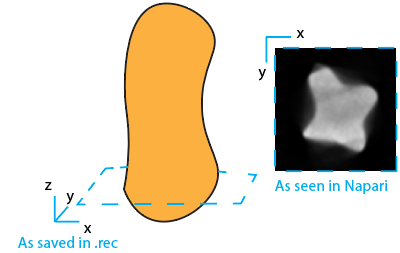

In [131]:
Q = iio.volread("Hausdorff_3D_TwistedPT.tif") # Let's assume this has been rotated in matlab before
print(Q.shape)
print(Q.shape[0]*Q.shape[1]*Q.shape[2])
print(np.count_nonzero(get_edges(Q)))

(93, 147, 93)
1271403
33359


2. Perform an initial grid search. Watch out! Computation cost scales with ${N_{parameters}}^6$ and ~ ${N_{voxels}}^1$

In [141]:
''' Parameters ''' 
n_shifts = 5 # for now, must be odd to include 0
l_shifts = 1 # in pixels
n_angles = 8 # 60 angles is quite good already, even is better with NR

distance = 'SE' # 'IoU', 'SE' or 'Hausdorff'

''' Function '''
if n_shifts == 0:
    iter_u = [0]
    iter_v = [0]
    iter_w = [0]
else:
    lim = (n_shifts // 2) * l_shifts
    iter_u = np.linspace(-1 * lim, lim, n_shifts,  dtype = 'int') # number of X points in the grid search, centered
    iter_v = np.linspace(-1 * lim, lim, n_shifts, dtype = 'int') # number of Y points in the grid search, centered
    iter_w = np.linspace(-1 * lim, lim, n_shifts, dtype = 'int') # number of Z points in the grid search, centered

iter_a = np.linspace(0, 360, n_angles, endpoint = False, dtype = 'int')
iter_b = np.linspace(0, 360, n_angles, endpoint = False, dtype = 'int')
iter_c = np.linspace(0, 360, n_angles, endpoint = False, dtype = 'int')

# Need to decouple col, row and angle idx to have a finer search with angles
# Also could have a "rod" or "sphere" case where less rotation are required

print(f'Grid search in u: {iter_u}')
print(f'Grid search in v: {iter_v}')
print(f'Grid search in w: {iter_w}')

print(f'Grid search in a: {iter_a}')
print(f'Grid search in b: {iter_b}')
print(f'Grid search in c: {iter_c}')

iter_param = [(u, v, w, a, b, c) 
              for u in iter_u
              for v in iter_v
              for w in iter_w 
              for a in iter_a
              for b in iter_b
              for c in iter_c]

Q_mirror = np.flip(Q, axis = 1)

print(f'The global minimum will be searched with {distance} over {len(iter_param)} combinations')
print(f'Estimated computation time: {eval_time_grid_search(Q, distance, iter_param)} s')

Grid search in u: [-2 -1  0  1  2]
Grid search in v: [-2 -1  0  1  2]
Grid search in w: [-2 -1  0  1  2]
Grid search in a: [  0  45  90 135 180 225 270 315]
Grid search in b: [  0  45  90 135 180 225 270 315]
Grid search in c: [  0  45  90 135 180 225 270 315]
The global minimum will be searched with SE over 64000 combinations
Estimated computation time: 445 s


In [135]:
''' Function '''
print(f'Searching the global minimum over {len(iter_param)} combinations ...')

# Multithreaded
to_CPU = [(Q, param, distance) for param in enumerate(iter_param)] # here param is [idx, (u, v, w, a, b, c)]

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [executor.submit(to_multiprocessing_3D, var) for var in to_CPU]
    H_global = [future.result() for future in concurrent.futures.as_completed(futures)]

# Retrieve results H_global [idx | distance]
H_global = np.array(H_global)
min_param_idx = H_global[np.argmin(H_global[:,1]), 0] # Get the lowest distance
min_param = iter_param[int(min_param_idx)]

# Rearrange H_global for [idx | u | v | alpha | distance]
H_global = H_global[np.argsort(H_global[:,0])] # Sort by idx
for i in range(len(iter_param[0])):
    H_global = np.insert(H_global, i+1, np.asarray(iter_param)[:,i], axis = 1) # Insert param

# Print results
print(f'global minimum found for parameters: {min_param} at D={H_global[:,-1].min()}')

show_param = 5 # Number of param to print
five_min = np.argsort(H_global[:,-1])[:show_param] 
print(f'{show_param} lowest parameters:\n {np.array(iter_param)[five_min]}')

Searching the global minimum over 125000 combinations ...
global minimum found for parameters: (-1, 0, 1, 0, 108, 180) at D=0.26084825234441605
5 lowest parameters:
 [[ -1   0   1   0 108 180]
 [ -1   0   1 180  72   0]
 [ -1   0   2 180  72   0]
 [ -1   0   2   0 108 180]
 [ -1   1   1 180  72   0]]


3. Starting from the best results of the grid search, perform a local search using the BFGS method

In [136]:
'''
Test to find the best step size depending on the metric used
Best step size gives a change of ~1e-3 for SE, ~1.5-2e-2 for IoU
It is best to have change_translate ~ change_rotation for convergence
Note: cannot have step size < 1 px
'''
test_step_size(Q, 'SE', min_param, step_rot = 2, step_translation = 1)

Average change for a translation step of 1 px: 2.156152e-03
Average change for a rotation step of 1°: 5.168372e-04


In [137]:
''' Parameters ''' 
step_rot = 2 # At the moment, need to be kept > 1
step_translation = 1 # At the moment, need to be kept > 1 and integers only
distance = 'SE' # 'SE', 'IoU' or 'Hausdorff'

''' Function '''
results = minimize_distance_local_3D(Q, distance, min_param, step_rot, step_translation)
best_param = descale_parameters(*results.x, step_rot, step_translation)

if distance == 'Hausdorff':
    d_max = regionprops(Q)[0].feret_diameter_max
    print(f'Hausdorff distance: {results.fun / d_max}')

minimizing the chirality distance from initialization: (-1, 0, 1, 0, 108, 180)


minimization completed after 2 iterations
Best parameters: [-1.03, -0.02, 0.99, -0.23, 108.17, 179.7] at 0.26
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.26070971867007675
        x: [ 1.000e+00  1.000e+00  1.000e+00  1.000e+00  1.001e+00
             1.001e+00]
      nit: 2
      jac: [ 2.707e+02  1.609e+02  1.034e+02  1.598e+02 -6.447e+01
             2.105e+02]
     nfev: 84
     njev: 12
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>


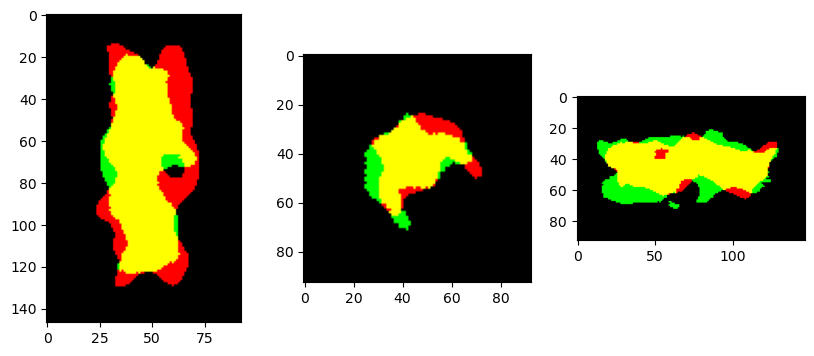

In [138]:
''' Display results in 2D'''
show_result_BFGS(Q, best_param)

In [139]:
''' Display results in 3D'''
show_result_BFGS(Q, best_param, V)